In [1]:

import os
import sys
sys.path.append("../../")
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
os.environ["JAX_PLATFORMS"] = "cuda"  # or: os.environ["JAX_PLATFORM_NAME"]="cuda"
#using GPU, comment out if on CPU?
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import jax
jax.config.update("jax_disable_jit", False)

jax.config.update("jax_debug_nans", True)
print(jax.lib.xla_bridge.get_backend().platform_version)  # sanity: shows CUDA/cuDNN


/tmp/ipykernel_853141/2309402995.py:16: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print(jax.lib.xla_bridge.get_backend().platform_version)  # sanity: shows CUDA/cuDNN


PJRT C API
cuda 12030


In [2]:
def side_by_side(mine,athenas,title):
    fig,ax = plt.subplots(1,2,figsize=(7,4),sharey=True)
    vmin,vmax = athenas.min(),athenas.max()
    ax[0].imshow(mine,vmin=vmin,vmax=vmax)
    ax[1].imshow(athenas,vmin=vmin,vmax=vmax)
    plt.show()

In [3]:
#load athena ICs
import h5py
import jax.numpy as jnp
from diffhydro.utils.io import athinput,athdf

athena_outputs_loc = "/gpfs02/work/bhorowitz/sims/blast_mhd/"

ic_filename = "Blast_MHD.out1.00000.athdf"


ICs = athdf(athena_outputs_loc+ic_filename)


In [4]:
ICs.keys()

dict_keys(['Coordinates', 'DatasetNames', 'MaxLevel', 'MeshBlockSize', 'NumCycles', 'NumMeshBlocks', 'NumVariables', 'RootGridSize', 'RootGridX1', 'RootGridX2', 'RootGridX3', 'Time', 'VariableNames', 'x1f', 'x1v', 'x2f', 'x2v', 'x3f', 'x3v', 'rho', 'press', 'vel1', 'vel2', 'vel3', 'Bcc1', 'Bcc2', 'Bcc3'])

In [5]:
#some strange index conventions, need to double check these... the axis gets a bit messed up but i think i plot them in the right order...
import jax.numpy as jnp
sol = jnp.zeros((8,64,64,64))

sol = sol.at[0].set(ICs["rho"])
sol = sol.at[1].set(ICs["vel2"])
sol = sol.at[2].set(ICs["vel1"])
sol = sol.at[3].set(ICs["vel3"])

sol = sol.at[4].set(ICs["Bcc2"])
sol = sol.at[5].set(ICs["Bcc1"])
sol = sol.at[6].set(ICs["Bcc3"])

sol = sol.at[7].set(ICs["press"])

2025-10-26 09:25:43.228532: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.6 which is older than the PTX compiler version 12.9.86. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [6]:
import diffhydro as dh

eq = dh.equationmanager_mhd.EquationManagerMHD()

ic = sol

In [7]:
#ic[-1]

In [8]:
#start with basic HLL

ss = None #this isn't used in MHD 

solver = dh.HLLD_MHD(equation_manager=eq,signal_speed=ss)

cf = dh.ConvectiveFlux(eq,solver,dh.MUSCL3(limiter="SUPERBEE"),positivity=False)
hydro = dh.hydro(n_super_step=75, fluxes=[cf],use_mol=True, integrator="SSPRK3")

using CTU? False


In [9]:
params = {}
output = hydro.evolve(sol,params)
field_out = output[0]

dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>, 10000000000.0]
using CTU? False


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


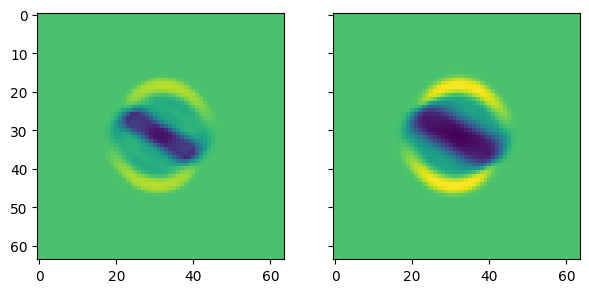

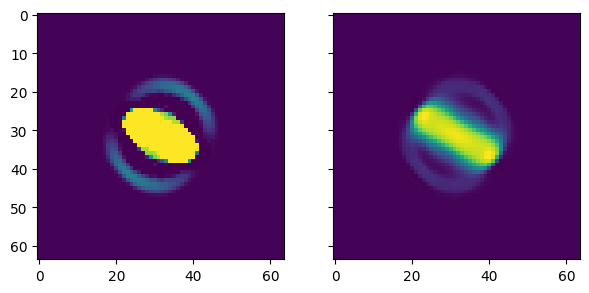

In [10]:
%pylab inline

#reference image...
fc_filename = "Blast_MHD.out1.00002.athdf"

FCs = athdf(athena_outputs_loc+fc_filename)
field_out_prim = field_out

side_by_side(field_out_prim[5][:,:,32],FCs["Bcc1"][32],None)

side_by_side(field_out_prim[-1][:,:,32],FCs["press"][32],None)


In [12]:
#all the things! CTU probably buggy?
eq = dh.equationmanager_mhd.EquationManagerMHD()
eq.cfl = 0.3
solver = dh.HLLD_MHD(equation_manager=eq,signal_speed=ss)

cf = dh.ConvectiveFlux(eq,solver,dh.MUSCL3(limiter="SUPERBEE"),positivity=False)
ppct = dh.mhd.PPCTForce(eq,boundary=dh.NoBoundary)  # pass a boundary, it might work... untested

hydro = dh.hydro(
    n_super_step=75,
    fluxes=[cf], 
    forces=[ppct],           # PPCT half-steps wrap the hydro update automatically
    use_mol=True,
    use_ctu=True, #still debugging the CT implementation in the CTU + CT, currently just using PPCT for the CT
    integrator="RK2"
)

output_CTU = hydro.evolve(ic,params)

using CTU? True
dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>, 10000000000.0]
using CTU? True
CTU
CTU


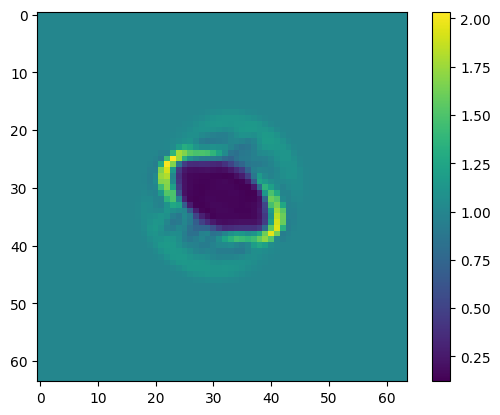

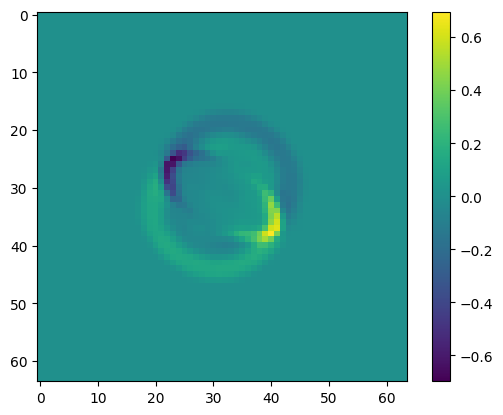

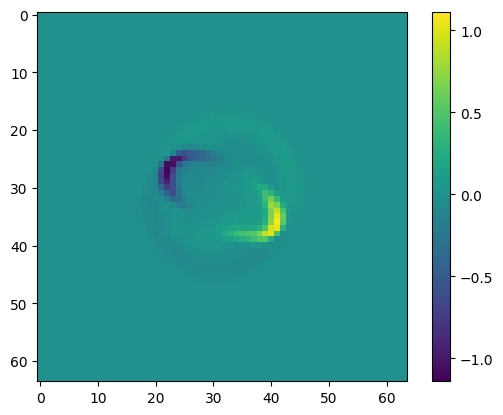

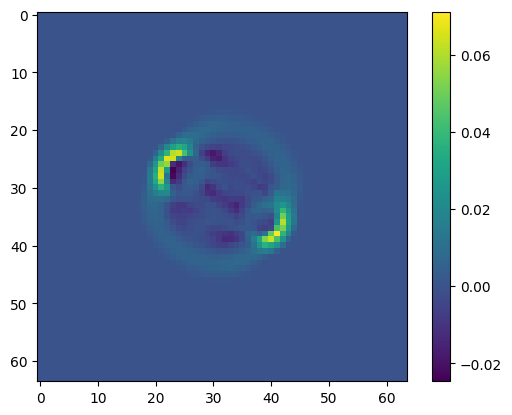

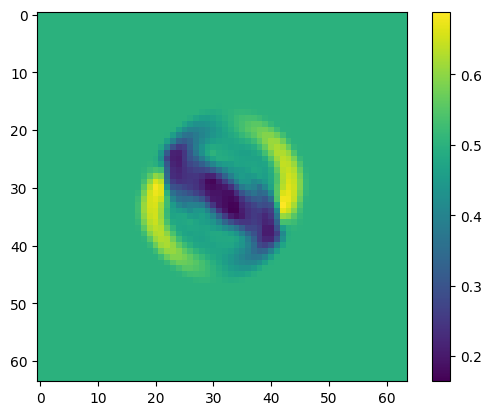

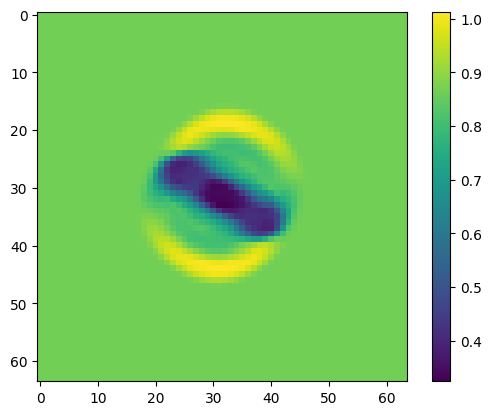

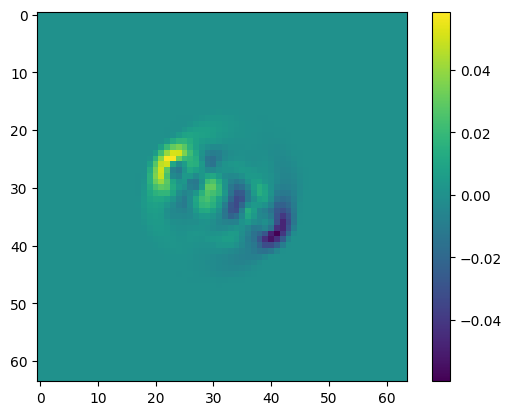

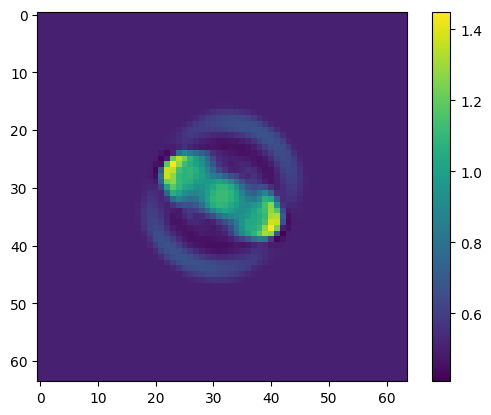

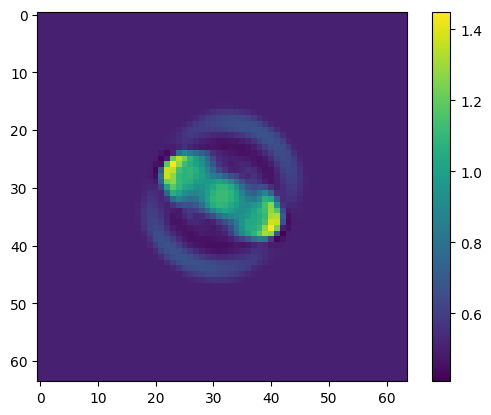

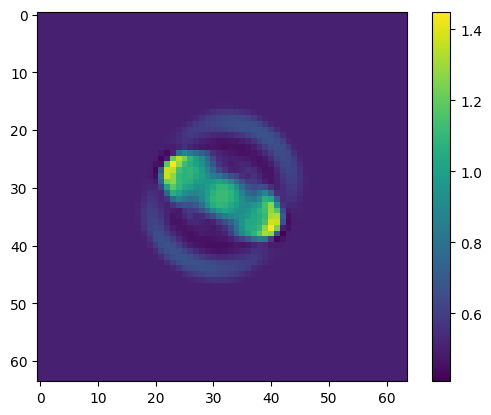

In [13]:

field_out_i = output_CTU[0]
field_out_CTU = field_out_i

for i in range(0,10):
    imshow(field_out_CTU[i][:,:,32])
    colorbar()
    show()

CTU?


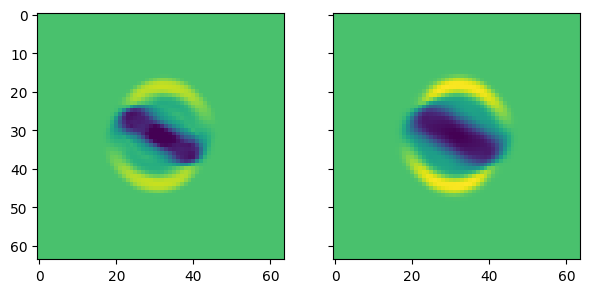

baseline


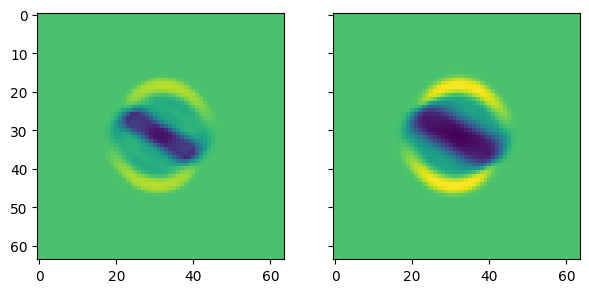

In [14]:

print("CTU?")
side_by_side(field_out_CTU[5][:,:,32],FCs["Bcc1"][32],None)

print("baseline")
side_by_side(field_out[5][:,:,32],FCs["Bcc1"][32],None)

CTU?


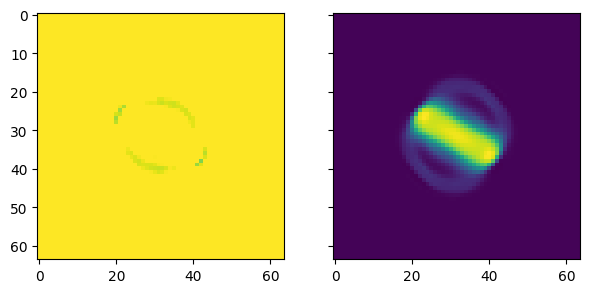

baseline


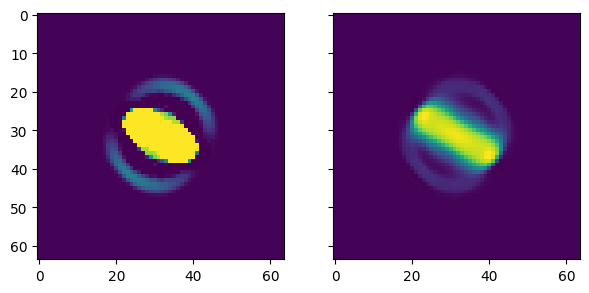

In [15]:

print("CTU?")
side_by_side(field_out_CTU[-1][:,:,32],FCs["press"][32],None)

print("baseline")

side_by_side(field_out_prim[-1][:,:,32],FCs["press"][32],None)


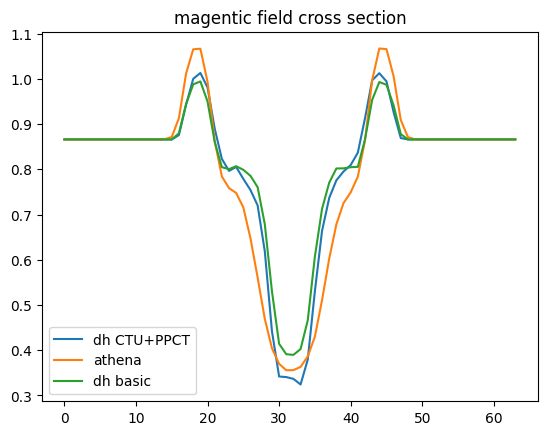

In [16]:
plt.title("magentic field cross section")
plt.plot(field_out_CTU[5][:,32,32],label="dh CTU+PPCT")
plt.plot(FCs["Bcc1"][32,:,32],label="athena")
plt.plot(field_out_prim[5][:,32,32],label="dh basic")
plt.legend()


In [ ]:
plt.title("pressure cross section")
plt.plot(field_out_CTU[-1][:,32,32]-0.4,label="dh CTU+PPCT")
plt.plot(FCs["press"][32,:,32],label="athena")
plt.plot(field_out_prim[-1][:,32,32],label="dh basic")
plt.legend()
plt.ylim(0,1)
